In [1]:
import os
data_dir = "../aistplusplus"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import yaml
from pathlib import Path
import random

import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pickle, time
import json, math
import pandas as pd

from src.data.dataset.loader import AISTDataset
from src.data.dataset import base
from src.data.dataset.cluster_misc import lexicon
from src.algo.kmeans_skl import Clusterer, get_best_clusterer

from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from src.data.dataset.cluster_misc import get_names
colours = list(mcolors.TABLEAU_COLORS)
classes = lexicon

#### After running `python pretrain.py --cfg configs/tan.yaml` and `python cluster.py --cfg configs/tan.yaml`, let's check its results

In [4]:
K = 150
exp_name = "tan"
word_df = pd.read_pickle(f"./logs/{exp_name}/advanced_tr_{K}.pkl")

#### Look into how our two-stage frame work tokenized a specific video

In [5]:
word_df[word_df["name"]=="gJB_sFM_cAll_d08_mJB4_ch12"]

,idx,word,length,y,name
3819,1,ago,111,131,gJB_sFM_cAll_d08_mJB4_ch12
3820,2,ahg,7,131,gJB_sFM_cAll_d08_mJB4_ch12
3821,3,ach,343,131,gJB_sFM_cAll_d08_mJB4_ch12
3822,4,adl,3,131,gJB_sFM_cAll_d08_mJB4_ch12
3823,5,ach,122,131,gJB_sFM_cAll_d08_mJB4_ch12
3824,6,adl,4,131,gJB_sFM_cAll_d08_mJB4_ch12
3825,7,ach,8,131,gJB_sFM_cAll_d08_mJB4_ch12
3826,8,adl,7,131,gJB_sFM_cAll_d08_mJB4_ch12
3827,9,ach,79,131,gJB_sFM_cAll_d08_mJB4_ch12
3828,10,adl,6,131,gJB_sFM_cAll_d08_mJB4_ch12


#### Plot for more videos, with dot size indicating the length of acton and color indicating acton class

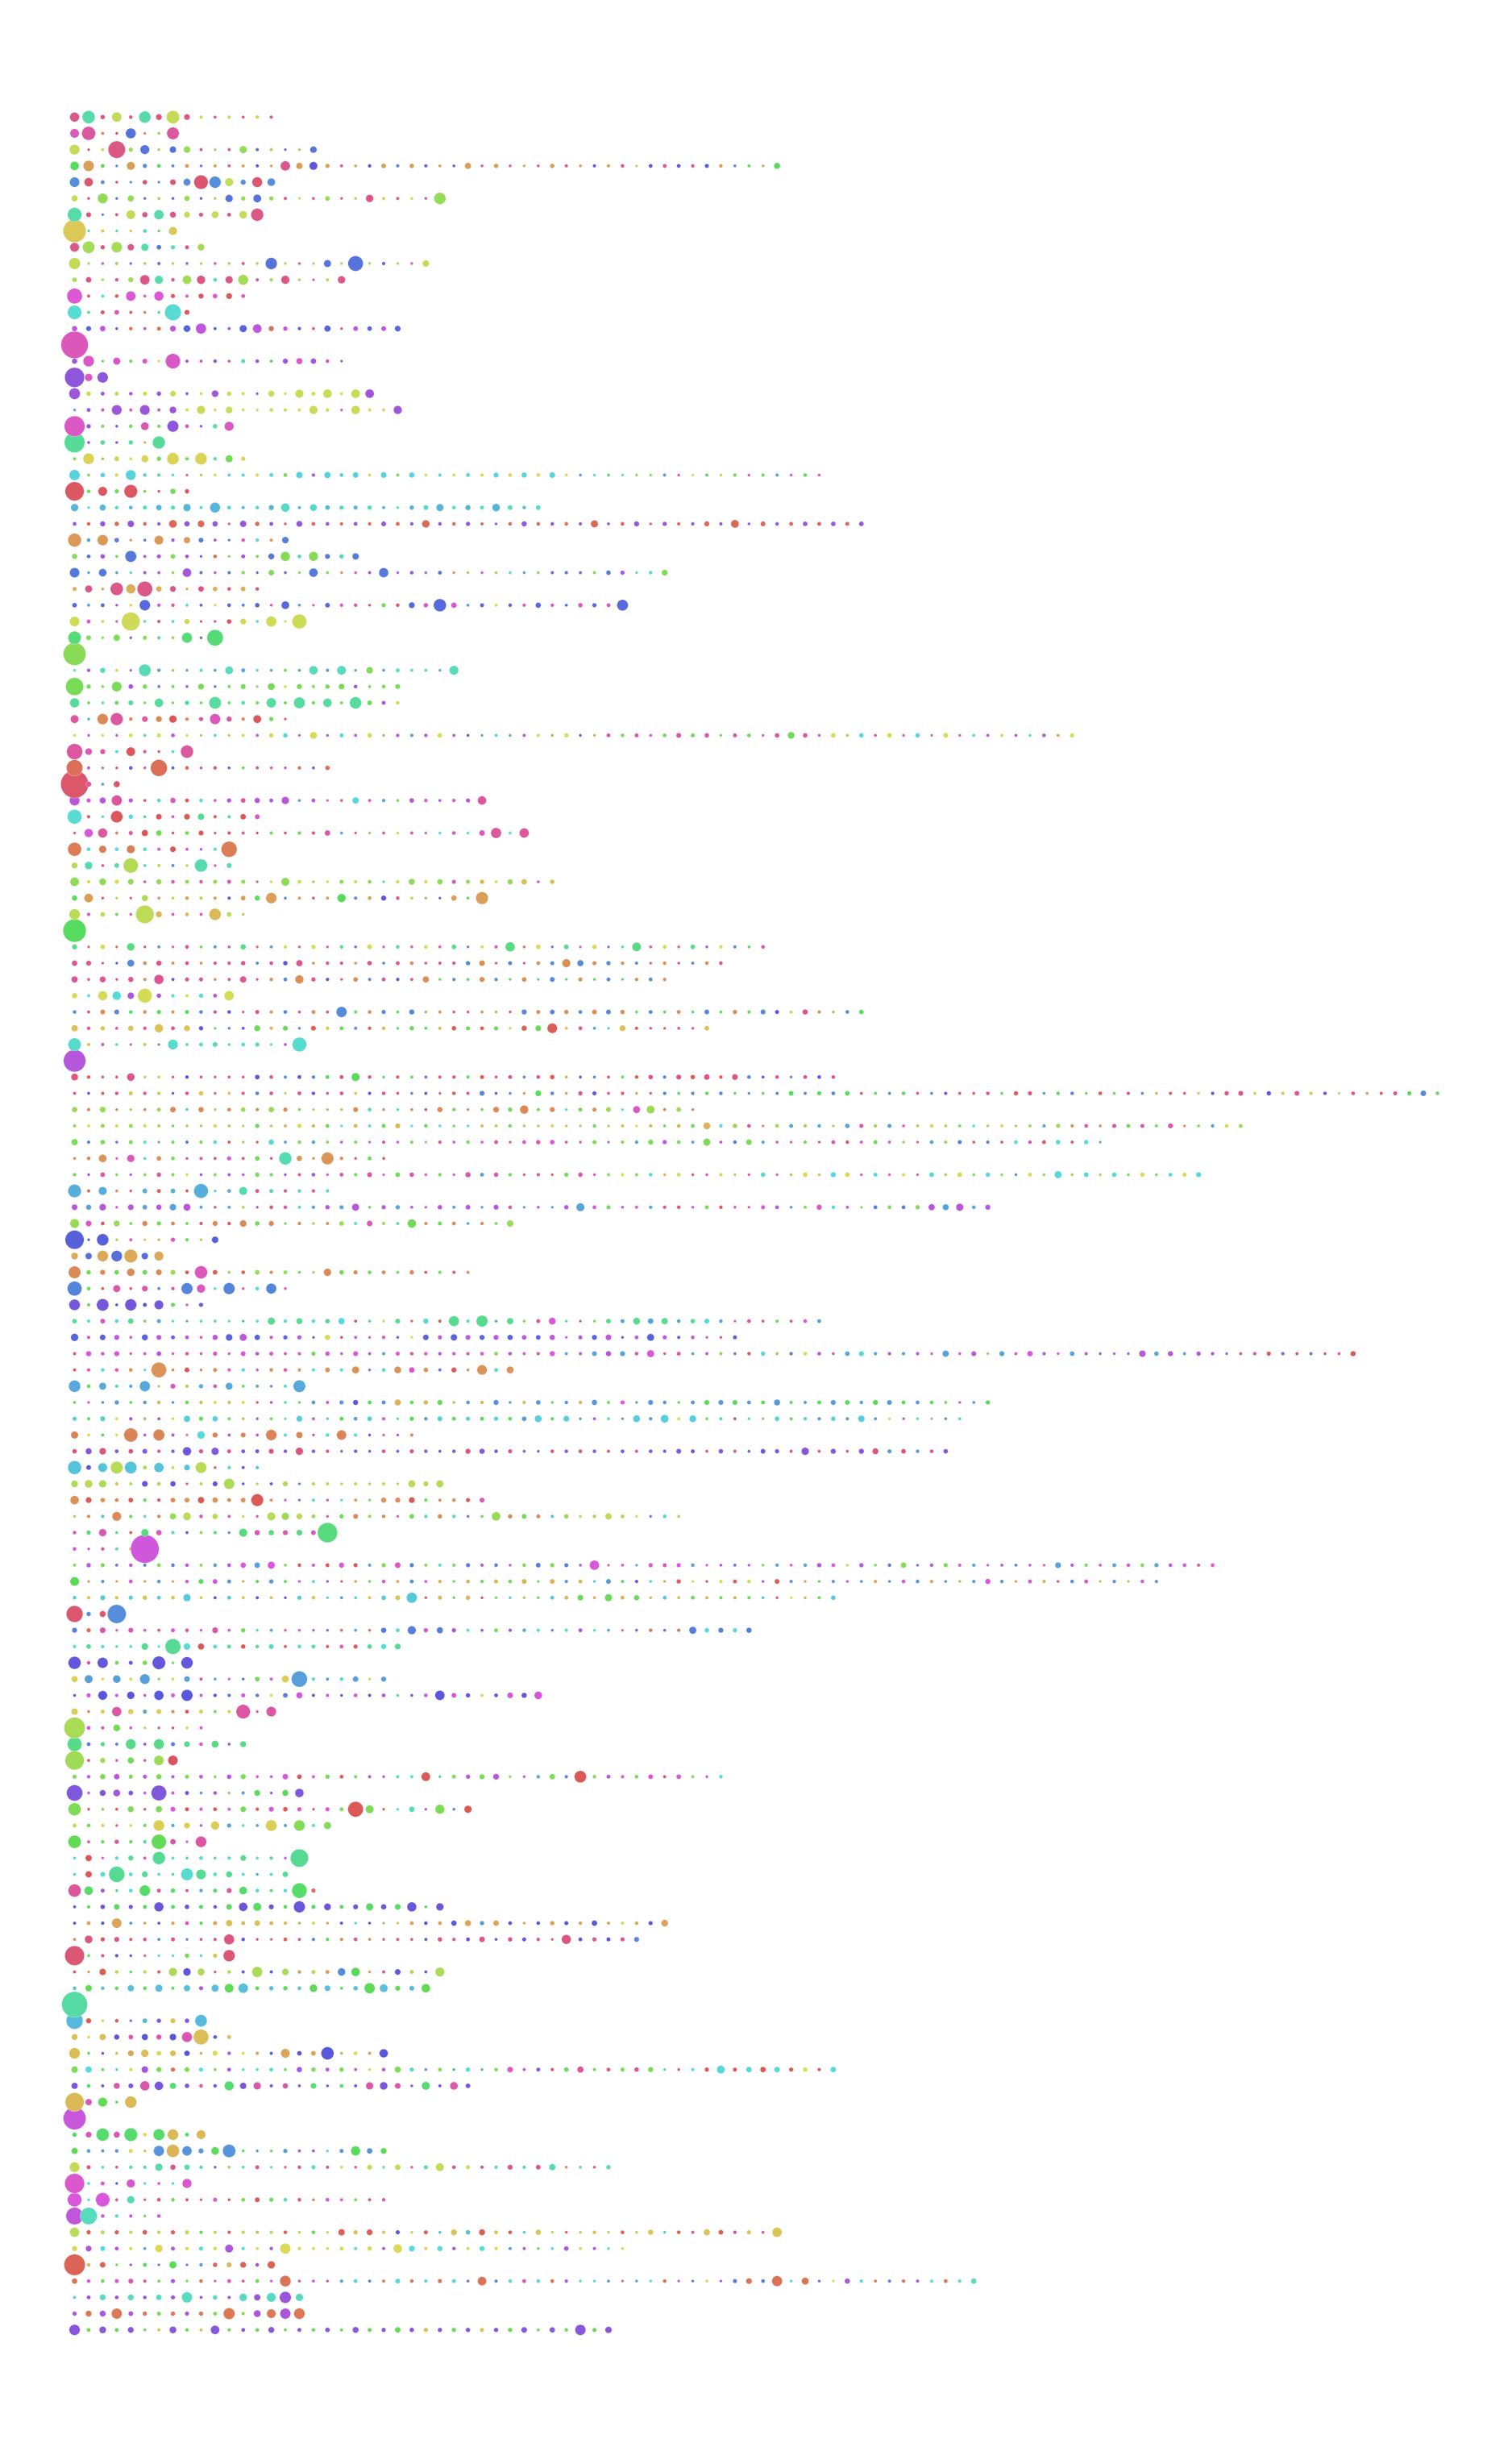

In [6]:
fig, ax = plt.subplots(figsize=(30, 50), dpi= 80, facecolor='w', edgecolor='k')
ax.axis('off')
words = list(word_df["word"])
perm = np.random.permutation(len(words))
mapping = {word: per for word, per in zip(words, perm)}
new_word_df = pd.DataFrame(columns=word_df.columns)
for rows in word_df.iterrows():
    rows = dict(rows[1])
    rows["word"] = mapping[rows["word"]]
    new_word_df = new_word_df.append(rows, ignore_index=True)
gg = sns.scatterplot(data=new_word_df, x="idx", y="y", hue="word", size="length", ax=ax, sizes=(10, 1000), legend=0, palette=sns.color_palette("hls", len(set(new_word_df["word"]))))

#### Use this tokenzation for downstream tasks that interest you...